# ch04.02 UNet-Image segmentation

* 날짜:
* 이름:

## 학습내용
    - Image multiclass segmentation에 대해 이해한다.
    - 이미지 분절 작업을 수행한다.

## Muticlass Segmenation



<p  align='center'>
<img src ='https://miro.medium.com/max/1400/1*B16t8Do6hvuq2Q_2YOM-UQ.png' width=500>
</p>


<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0402-01.PNG?raw=true' width=800>
</p>


In [1]:
# 세팅
! git clone https://github.com/karolzak/keras-unet

Cloning into 'keras-unet'...
remote: Enumerating objects: 1234, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1234 (delta 44), reused 75 (delta 34), pack-reused 1136
Receiving objects: 100% (1234/1234), 31.94 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (372/372), done.


In [2]:
import sys, os, glob
sys.path.append('/content/keras-unet')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import utils, callbacks, models, layers
from keras_unet.models import custom_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## 데이터셋: Crowd Instance-level Human Parsing (CIHP)
---

(https://arxiv.org/abs/1811.12596)

* 38,280개의 다양한 인간 이미지
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/chip.png?raw=true)

In [3]:
!gdown https://drive.google.com/u/0/uc?id=10p_-JQ8T7EuOJ1AWLSQpkUcrIhtRJgK_&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=10p_-JQ8T7EuOJ1AWLSQpkUcrIhtRJgK_
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:12<00:00, 230MB/s] 


In [4]:
!unzip -q instance-level-human-parsing.zip

In [16]:
data_dir = '/content/instance-level_human_parsing/instance-level_human_parsing/'

train_img_paths = sorted(glob.glob(f'{data_dir}/Training/Images/*'))
train_mask_paths = sorted(glob.glob(f'{data_dir}/Training/Category_ids/*'))
print(len(train_img_paths), train_img_paths[0])
print(len(train_mask_paths), train_mask_paths[0])

valid_img_paths = sorted(glob.glob(f'{data_dir}/Validation/Images/*'))
valid_mask_paths = sorted(glob.glob(f'{data_dir}/Validation/Category_ids/*'))
print(len(valid_img_paths), valid_img_paths[0])
print(len(valid_mask_paths), valid_mask_paths[0])

28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Images/0000006.jpg
28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Category_ids/0000006.png
5000 /content/instance-level_human_parsing/instance-level_human_parsing//Validation/Images/0000001.jpg
5000 /content/instance-level_human_parsing/instance-level_human_parsing//Validation/Category_ids/0000001.png


In [6]:
# 안전한 방법
train_img_paths = [mask_path.replace('png','jpg') for mask_path in train_mask_paths]
print(len(train_img_paths), train_img_paths[0])
train_img_paths = [img_path.replace('Category_ids','Images') for img_path in train_img_paths]
print(len(train_img_paths), train_img_paths[0])

28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Category_ids/0014171.jpg
28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Images/0014171.jpg


In [7]:
# for문 사용해서 numpy 배열로 바꾸면 ram 터짐

# imgs = []
# masks = []
# for img_path, mask_path in zip(train_img_paths[:10], train_mask_paths[:10]):
#   # print(img_path, mask_path)
#   # path2img
#   img = Image.open(img_path).resize( (128,128) )
#   img = np.array(img)
#   # path2mask
#   mask = Image.open(mask_path).resize( (128,128) )
#   mask = np.array(mask)
#   imgs.append(img)
#   masks.append(mask)
# imgs = np.asarray(imgs)
# masks = np.asarray(masks)
# masks = np.expand_dims(masks, 3)
# imgs.shape, masks.shape


In [53]:
# for 루프 대신에 map을 사용
# map에 들어갈 함수 특징: 리스트가 아니라 scalar 를 받는다.
def path2tensor(image_path, mask_path, IMAGE_SIZE=128): # 이미지 경로 한개, 마스크 경로 한개
    # 이미지 처리
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.               # 127.5 - 1 : 는 -1부터 1사이 값  255:는 0부터 1사이 값

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask.set_shape([None, None, 1])
    mask = tf.image.resize(images=mask, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image, mask


def aug(image, mask, seed=123):
  image = tf.image.random_brightness(image, 0.2) # 랜덤 밝기 -> 이미지만
  image = tf.image.random_contrast(image, 0.2, 0.5) # 랜덤 대비 -> 이미지만
  # 이미지 - 마스크 같이 변환
  stacked = tf.concat([image, mask], axis=2)
  stacked = tf.image.random_flip_left_right(stacked, seed=seed)  # 랜덤 좌우반전 -> 이미지, 마스크
  stacked = tf.image.random_flip_up_down(stacked, seed=seed) # 상하반전
  

  image = stacked[:,:,:3]
  mask = tf.reshape(stacked[:,:,-1], (128, 128,1))
  return image, mask









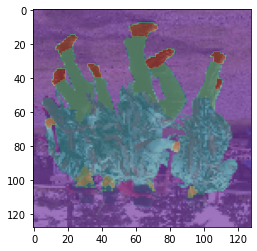

In [54]:
img, mask = path2tensor(train_img_paths[2], train_mask_paths[2])
img, mask = aug(img, mask)
plt.imshow(img);plt.imshow(mask[:,:,0], alpha=.3, cmap='rainbow')

In [55]:
train_ds = tf.data.Dataset.from_tensor_slices((train_img_paths, train_mask_paths))
train_ds = train_ds.map(path2tensor, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(aug)
train_ds = train_ds.batch(32, drop_remainder=True)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_mask_paths))
valid_ds = valid_ds.map(path2tensor, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(32, drop_remainder=True)


print(train_ds)
print(valid_ds)

<BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.float32, name=None))>


(128, 128, 1) (32, 128, 128)


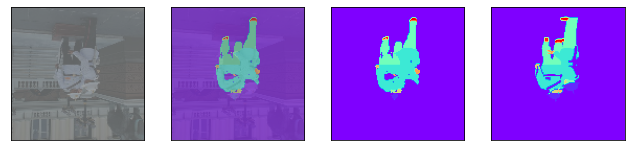

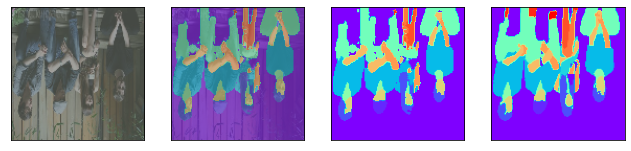

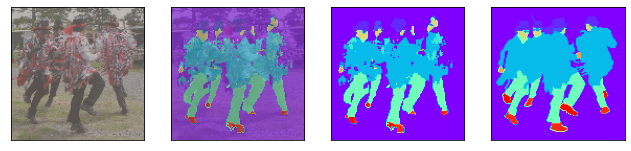

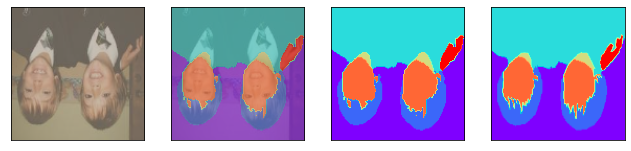

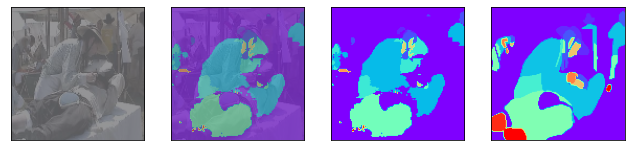

In [62]:
for imgs, masks in train_ds.take(1):
  N=5
  preds = model.predict(imgs)
  preds = tf.argmax(preds, 3)
  print(mask.shape, preds.shape)
  for img, mask, pred in zip(imgs[:N], masks[:N], preds[:N]):
    plt.figure(figsize=(11,4))
    plt.subplot(141);plt.imshow(img);plt.xticks([]);plt.yticks([])
    plt.subplot(142);plt.imshow(img);plt.imshow(pred, alpha=.5, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(143);plt.imshow(pred, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(144);plt.imshow(mask[:,:,0], cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.show()

# 모델 준비

In [12]:
model = custom_unet((128,128,3), 
                    num_classes=20,
                    filters=32,
                    output_activation='softmax')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [60]:
def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [61]:
ckp = callbacks.ModelCheckpoint(filepath='model.h5',# 모델 저장 경로
                                save_best_only=True, # 가장 성능이 좋은 모델만 저장
                                monitor='val_loss'  # 어떤 값을 기준으로 성능 측정할것인가
                                )

tb = callbacks.TensorBoard(log_dir='my_log_dir', histogram_freq=1)

history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[ckp, tb])

Epoch 1/50
883/883 [==============================] - 88s 96ms/step - loss: 1.6230 - acc: 0.5667 - val_loss: 1.3076 - val_acc: 0.6129
Epoch 2/50
883/883 [==============================] - 126s 143ms/step - loss: 1.2446 - acc: 0.6315 - val_loss: 1.0558 - val_acc: 0.6778
Epoch 3/50
883/883 [==============================] - 112s 127ms/step - loss: 1.0331 - acc: 0.6810 - val_loss: 0.9363 - val_acc: 0.7090
Epoch 4/50
883/883 [==============================] - 89s 101ms/step - loss: 0.9235 - acc: 0.7095 - val_loss: 0.8636 - val_acc: 0.7275
Epoch 5/50
883/883 [==============================] - 88s 100ms/step - loss: 0.8618 - acc: 0.7268 - val_loss: 0.8400 - val_acc: 0.7360
Epoch 6/50
883/883 [==============================] - 96s 109ms/step - loss: 0.8193 - acc: 0.7394 - val_loss: 0.7914 - val_acc: 0.7480
Epoch 7/50
883/883 [==============================] - 105s 119ms/step - loss: 0.7855 - acc: 0.7494 - val_loss: 0.7802 - val_acc: 0.7505
Epoch 8/50
883/883 [==============================] -

(128, 128, 1) (32, 128, 128)


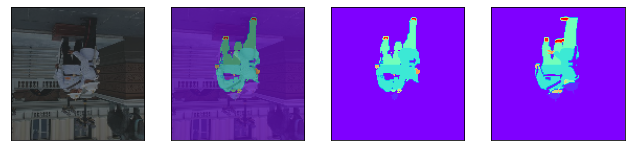

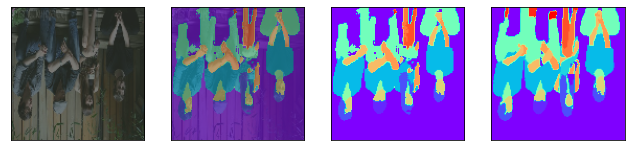

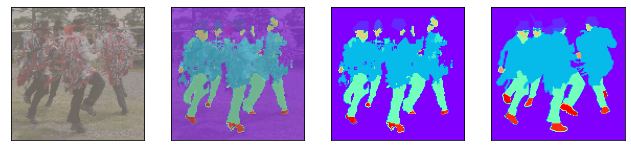

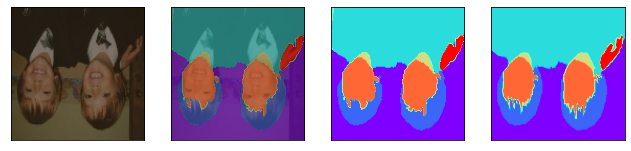

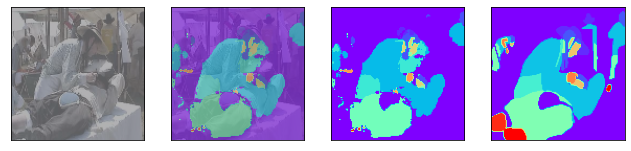

In [63]:
for imgs, masks in train_ds.take(1):
  N=5
  preds = model.predict(imgs)
  preds = tf.argmax(preds, 3)
  print(mask.shape, preds.shape)
  for img, mask, pred in zip(imgs[:N], masks[:N], preds[:N]):
    plt.figure(figsize=(11,4))
    plt.subplot(141);plt.imshow(img);plt.xticks([]);plt.yticks([])
    plt.subplot(142);plt.imshow(img);plt.imshow(pred, alpha=.5, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(143);plt.imshow(pred, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(144);plt.imshow(mask[:,:,0], cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.show()